In [1]:
import albumentations as A
import os
import cv2
import numpy as np
import tifffile
from sklearn.model_selection import train_test_split
from cellpose import models, train, io
import matplotlib.pyplot as plt
from cellpose import plot
from cellpose import utils, io

io.logger_setup()  # Run this to get printing of progress

# Define paths
data_dir = '/root/capsule/data/iGluSnFR_Soma_Annotation'

# Collect all image and mask file paths
image_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_merged.tif')])
mask_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_segmented_v2.tif')])

# Ensure that each image has a corresponding mask
assert len(image_files) == len(mask_files), "Number of images and masks must match."

# Load all images and masks
images = [tifffile.imread(os.path.join(data_dir, img))[:, 1, :, :] for img in image_files]
masks = [tifffile.imread(os.path.join(data_dir, msk)) for msk in mask_files]

# Ensure images and masks have the same number of frames
for img, msk in zip(images, masks):
    assert img.shape[0] == msk.shape[0], "Number of frames in images and masks must match."

# Convert lists to numpy arrays
images = np.concatenate(images, axis=0)
masks = np.concatenate(masks, axis=0)

# Normalize images to 0-1 range
images = images.astype(np.float32) / 255.0

# Convert masks to uint8 if needed
masks_uint8 = masks.astype(np.uint8)

# Define an augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
], is_check_shapes=False)

augmented_images = []
augmented_masks = []

# Augment each image multiple times
num_augmentations = 5  # Number of times to augment each image

for img, msk in zip(images, masks_uint8):
    for _ in range(num_augmentations):
        # Apply the augmentation pipeline
        transformed = transform(image=img, mask=msk)
        augmented_images.append(transformed['image'])
        augmented_masks.append(transformed['mask'])

# Convert lists to numpy arrays and combine with original data
augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)

# Combine original and augmented data
images_combined = np.concatenate((images, augmented_images), axis=0)
masks_combined = np.concatenate((masks_uint8, augmented_masks), axis=0)

# Split data into train+val and test
train_val_images, test_images, train_val_masks, test_masks = train_test_split(
    images_combined, masks_combined, test_size=0.15, random_state=42
)

# Split train+val into train and validation
train_images, val_images, train_masks, val_masks = train_test_split(
    train_val_images, train_val_masks, test_size=0.176, random_state=42  # 0.176 to make validation 15% of total
)

# Initialize Cellpose model
model = models.CellposeModel(gpu=True, model_type='cyto')

# Train the model with augmented data
train.train_seg(
    model.net,
    train_data=train_images,
    train_labels=train_masks,
    test_data=val_images, 
    test_labels=val_masks,
    channels=[0, 0],  # Adjust channels if needed
    normalize=True,
    weight_decay=1e-4,
    SGD=False,
    learning_rate=0.1,
    n_epochs=1000,
    save_path='/root/capsule/scratch/caleb_cellpose/',
    model_name='custom_cellpose_model.pth'
)

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


2024-09-14 06:26:44,287 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log
2024-09-14 06:26:44,288 [INFO] 
cellpose version: 	3.0.11 
platform:       	linux 
python version: 	3.10.12 
torch version:  	2.1.0
2024-09-14 06:26:50,055 [INFO] >> cyto << model set to be used
2024-09-14 06:26:50,958 [INFO] ** TORCH CUDA version installed and working. **
2024-09-14 06:26:50,959 [INFO] >>>> using GPU (CUDA)
2024-09-14 06:26:51,043 [INFO] >>>> loading model /root/.cellpose/models/cytotorch_0
2024-09-14 06:26:51,088 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2024-09-14 06:26:51,089 [INFO] computing flows for labels


  6%|▌         | 44/705 [00:04<00:58, 11.34it/s]

2024-09-14 06:26:56,853 [WARNING] empty masks!


  9%|▉         | 64/705 [00:05<00:37, 17.12it/s]

2024-09-14 06:26:58,079 [WARNING] empty masks!


 15%|█▍        | 103/705 [00:08<00:29, 20.12it/s]

2024-09-14 06:27:00,427 [WARNING] empty masks!


 19%|█▉        | 136/705 [00:09<00:28, 19.91it/s]

2024-09-14 06:27:02,215 [WARNING] empty masks!


 21%|██        | 146/705 [00:10<00:36, 15.39it/s]

2024-09-14 06:27:02,831 [WARNING] empty masks!


 24%|██▍       | 171/705 [00:11<00:30, 17.44it/s]

2024-09-14 06:27:04,024 [WARNING] empty masks!


 30%|██▉       | 208/705 [00:14<00:44, 11.22it/s]

2024-09-14 06:27:07,054 [WARNING] empty masks!


 42%|████▏     | 293/705 [00:20<00:19, 20.79it/s]

2024-09-14 06:27:12,500 [WARNING] empty masks!


 42%|████▏     | 296/705 [00:20<00:23, 17.05it/s]

2024-09-14 06:27:12,787 [WARNING] empty masks!


 43%|████▎     | 303/705 [00:20<00:23, 17.33it/s]

2024-09-14 06:27:13,117 [WARNING] empty masks!


 55%|█████▌    | 389/705 [00:25<00:15, 20.46it/s]

2024-09-14 06:27:18,041 [WARNING] empty masks!


 56%|█████▋    | 397/705 [00:26<00:21, 14.50it/s]

2024-09-14 06:27:18,475 [WARNING] empty masks!


 61%|██████▏   | 432/705 [00:28<00:14, 18.73it/s]

2024-09-14 06:27:20,454 [WARNING] empty masks!


 67%|██████▋   | 474/705 [00:30<00:14, 15.48it/s]

2024-09-14 06:27:22,739 [WARNING] empty masks!


 69%|██████▉   | 485/705 [00:31<00:22,  9.92it/s]

2024-09-14 06:27:23,856 [WARNING] empty masks!


 73%|███████▎  | 515/705 [00:34<00:19,  9.61it/s]

2024-09-14 06:27:26,510 [WARNING] empty masks!


 75%|███████▍  | 526/705 [00:35<00:12, 14.16it/s]

2024-09-14 06:27:27,322 [WARNING] empty masks!


 92%|█████████▏| 646/705 [00:42<00:04, 13.34it/s]

2024-09-14 06:27:34,554 [WARNING] empty masks!


 99%|█████████▉| 699/705 [00:45<00:00, 19.00it/s]

2024-09-14 06:27:37,900 [WARNING] empty masks!


100%|█████████▉| 703/705 [00:45<00:00, 22.09it/s]

2024-09-14 06:27:38,106 [WARNING] empty masks!


100%|██████████| 705/705 [00:45<00:00, 15.36it/s]

2024-09-14 06:27:38,112 [INFO] computing flows for labels



 35%|███▌      | 53/151 [00:03<00:07, 12.88it/s]

2024-09-14 06:27:42,381 [WARNING] empty masks!


 37%|███▋      | 56/151 [00:04<00:05, 16.05it/s]

2024-09-14 06:27:42,520 [WARNING] empty masks!


 48%|████▊     | 73/151 [00:05<00:05, 15.25it/s]

2024-09-14 06:27:43,741 [WARNING] empty masks!


 52%|█████▏    | 79/151 [00:05<00:04, 15.98it/s]

2024-09-14 06:27:44,117 [WARNING] empty masks!


 57%|█████▋    | 86/151 [00:05<00:03, 20.20it/s]

2024-09-14 06:27:44,345 [WARNING] empty masks!


 85%|████████▍ | 128/151 [00:08<00:01, 18.51it/s]

2024-09-14 06:27:46,911 [WARNING] empty masks!


100%|██████████| 151/151 [00:10<00:00, 14.93it/s]

2024-09-14 06:27:48,469 [INFO] >>> computing diameters



  6%|▌         | 44/705 [00:00<00:03, 217.95it/s]/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 151/151 [00:00<00:00, 217.89it/s]

2024-09-14 06:27:52,410 [WARNING] 121 train images with number of masks less than min_train_masks (5), removing from train set
2024-09-14 06:27:52,411 [INFO] >>> using channels [0, 0]
2024-09-14 06:27:52,412 [INFO] >>> normalizing {'lowhigh': None, 'percentile': None, 'normalize': True, 'norm3D': False, 'sharpen_radius': 0, 'smooth_radius': 0, 'tile_norm_blocksize': 0, 'tile_norm_smooth3D': 1, 'invert': False}


2024-09-14 06:28:18,966 [INFO] >>> n_epochs=1000, n_train=584, n_test=151
2024-09-14 06:28:18,967 [INFO] >>> AdamW, learning_rate=0.10000, weight_decay=0.00010
2024-09-14 06:28:19,208 [INFO] >>> saving model to /root/capsule/scratch/caleb_cellpose/models/custom_cellpose_model.pth


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


2024-09-14 06:28:33,436 [INFO] 0, train_loss=1.6899, test_loss=1.5463, LR=0.0000, time 14.23s
2024-09-14 06:29:31,979 [INFO] 5, train_loss=0.1749, test_loss=0.1464, LR=0.0556, time 72.77s
2024-09-14 06:30:30,428 [INFO] 10, train_loss=0.1111, test_loss=0.1142, LR=0.1000, time 131.22s
2024-09-14 06:32:26,027 [INFO] 20, train_loss=0.0968, test_loss=0.0982, LR=0.1000, time 246.82s
2024-09-14 06:34:21,346 [INFO] 30, train_loss=0.0888, test_loss=0.0761, LR=0.1000, time 362.14s
2024-09-14 06:36:16,826 [INFO] 40, train_loss=0.0869, test_loss=0.0932, LR=0.1000, time 477.62s
2024-09-14 06:38:12,290 [INFO] 50, train_loss=0.0855, test_loss=0.0890, LR=0.1000, time 593.09s
2024-09-14 06:40:07,805 [INFO] 60, train_loss=0.0847, test_loss=0.0873, LR=0.1000, time 708.60s
2024-09-14 06:42:03,177 [INFO] 70, train_loss=0.0845, test_loss=0.0739, LR=0.1000, time 823.97s
2024-09-14 06:43:58,685 [INFO] 80, train_loss=0.0809, test_loss=0.0725, LR=0.1000, time 939.48s
2024-09-14 06:45:54,280 [INFO] 90, train_los

PosixPath('/root/capsule/scratch/caleb_cellpose/models/custom_cellpose_model.pth')

In [1]:
# Load cellpose model
from cellpose import models

def load_cellpose_modelpath(model_path: str,
                            gpu: bool = True) -> models.CellposeModel:

    # load cellpose model
    print('Loading Cellpose Models from folder ...')
    model = models.CellposeModel(gpu=True, pretrained_model=model_path)

    return model

model = load_cellpose_modelpath('/root/capsule/scratch/caleb_cellpose/models/custom_cellpose_model.pth')

import albumentations as A
import os
import cv2
import numpy as np
import tifffile
from sklearn.model_selection import train_test_split
from cellpose import models, train, io
import matplotlib.pyplot as plt
from cellpose import plot
from cellpose import utils, io

io.logger_setup()  # Run this to get printing of progress

# Define paths
data_dir = '/root/capsule/data/iGluSnFR_Soma_Annotation'

# Collect all image and mask file paths
image_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_merged.tif')])
mask_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_segmented_v2.tif')])

# Ensure that each image has a corresponding mask
assert len(image_files) == len(mask_files), "Number of images and masks must match."

# Load all images and masks
images = [tifffile.imread(os.path.join(data_dir, img))[:, 1, :, :] for img in image_files]
masks = [tifffile.imread(os.path.join(data_dir, msk)) for msk in mask_files]

# Ensure images and masks have the same number of frames
for img, msk in zip(images, masks):
    assert img.shape[0] == msk.shape[0], "Number of frames in images and masks must match."

# Convert lists to numpy arrays
images = np.concatenate(images, axis=0)
masks = np.concatenate(masks, axis=0)

# Normalize images to 0-1 range
images = images.astype(np.float32) / 255.0

# Convert masks to uint8 if needed
masks_uint8 = masks.astype(np.uint8)

# Define an augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
], is_check_shapes=False)

augmented_images = []
augmented_masks = []

# Augment each image multiple times
num_augmentations = 5  # Number of times to augment each image

for img, msk in zip(images, masks_uint8):
    for _ in range(num_augmentations):
        # Apply the augmentation pipeline
        transformed = transform(image=img, mask=msk)
        augmented_images.append(transformed['image'])
        augmented_masks.append(transformed['mask'])

# Convert lists to numpy arrays and combine with original data
augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)

# Combine original and augmented data
images_combined = np.concatenate((images, augmented_images), axis=0)
masks_combined = np.concatenate((masks_uint8, augmented_masks), axis=0)

# Split data into train+val and test
train_val_images, test_images, train_val_masks, test_masks = train_test_split(
    images_combined, masks_combined, test_size=0.15, random_state=42
)

# Split train+val into train and validation
train_images, val_images, train_masks, val_masks = train_test_split(
    train_val_images, train_val_masks, test_size=0.176, random_state=42  # 0.176 to make validation 15% of total
)

Loading Cellpose Models from folder ...


/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


2024-09-18 22:43:09,873 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log
2024-09-18 22:43:09,874 [INFO] 
cellpose version: 	3.0.12.dev87+g52f75f9 
platform:       	linux 
python version: 	3.10.12 
torch version:  	2.1.0


In [15]:
import numpy as np
import pandas as pd
from cellpose import models

# Prepare a list to store the results
results_list = []

# Define a function to calculate metrics
def calculate_metrics(true_mask, masks_pred):
    # Dice Score
    intersection = np.logical_and(true_mask, masks_pred)
    dice_score = 2. * intersection.sum() / (true_mask.sum() + masks_pred.sum())

    # IoU Score
    union = np.logical_or(true_mask, masks_pred)
    iou_score = intersection.sum() / union.sum() if union.sum() > 0 else 0

    # Pixel Accuracy
    pixel_accuracy = np.sum(true_mask == masks_pred) / true_mask.size

    # Number of ROIs
    num_rois_true = np.unique(true_mask).size - 1  # Exclude background
    num_rois_pred = np.unique(masks_pred).size - 1  # Exclude background

    return {
        "Dice Score": dice_score,
        "IoU Score": iou_score,
        "Pixel Accuracy": pixel_accuracy,
        "Number of True ROIs": num_rois_true,
        "Number of Predicted ROIs": num_rois_pred
    }

# Loop through all test images
for i, (image, true_mask) in enumerate(zip(test_images, test_masks)):
    # Evaluate the model on the test image
    results = model.eval(image, channels=[0, 0])
    if len(results) == 3:
        masks_pred, flows, styles = results
    else:
        masks_pred, flows, styles, diams = results

    # Calculate metrics
    metrics = calculate_metrics(true_mask, masks_pred)

    # Append results to the list
    results_list.append({
        'Image_Index': i,
        'Dice_Score': metrics['Dice Score'],
        'IoU_Score': metrics['IoU Score'],
        'Pixel_Accuracy': metrics['Pixel Accuracy'],
        'Number_of_True_ROIs': metrics['Number of True ROIs'],
        'Number_of_Predicted_ROIs': metrics['Number of Predicted ROIs']
    })

# Convert the list of results to a DataFrame
results_df = pd.DataFrame(results_list)

# Save results to a CSV file
results_df.to_csv('/root/capsule/scratch/caleb_cellpose/evaluation_results.csv', index=False)

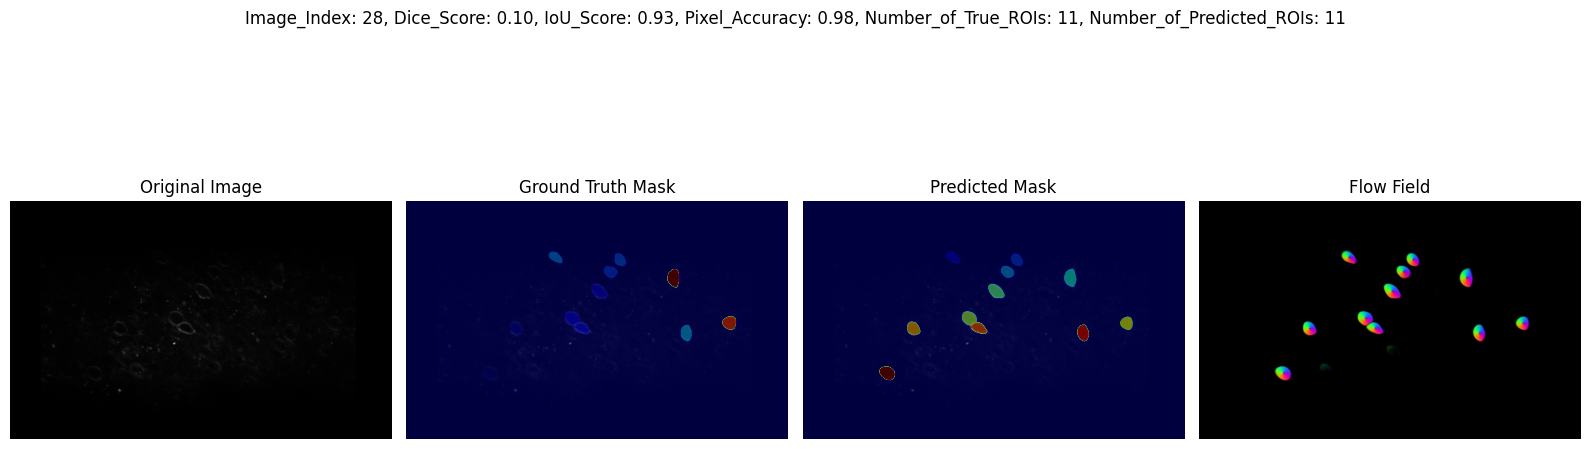

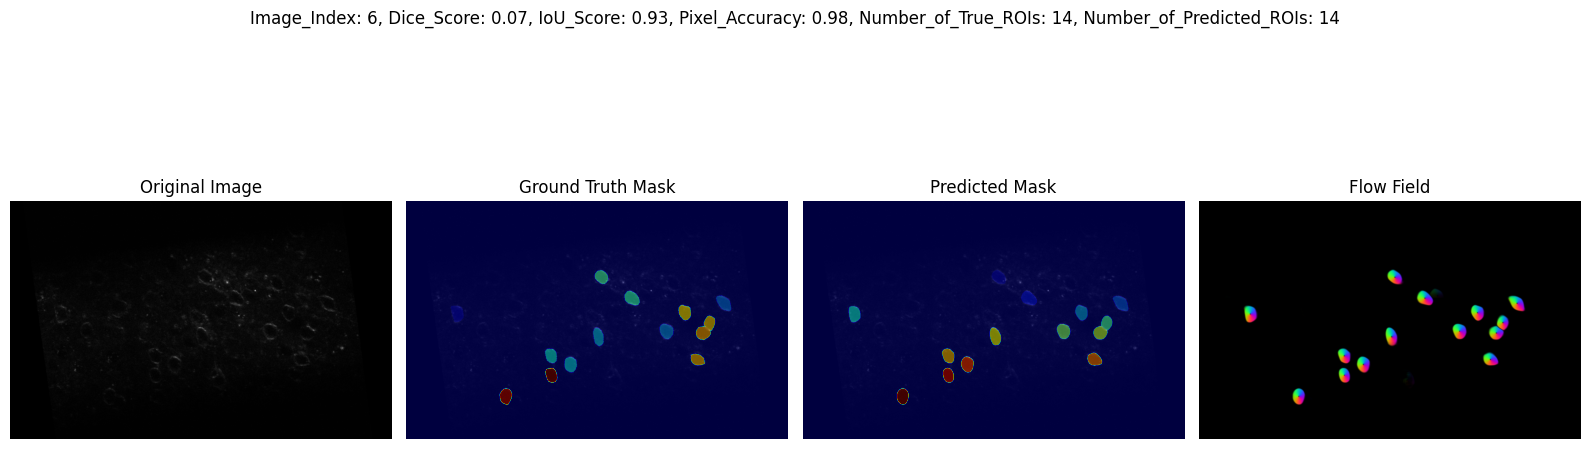

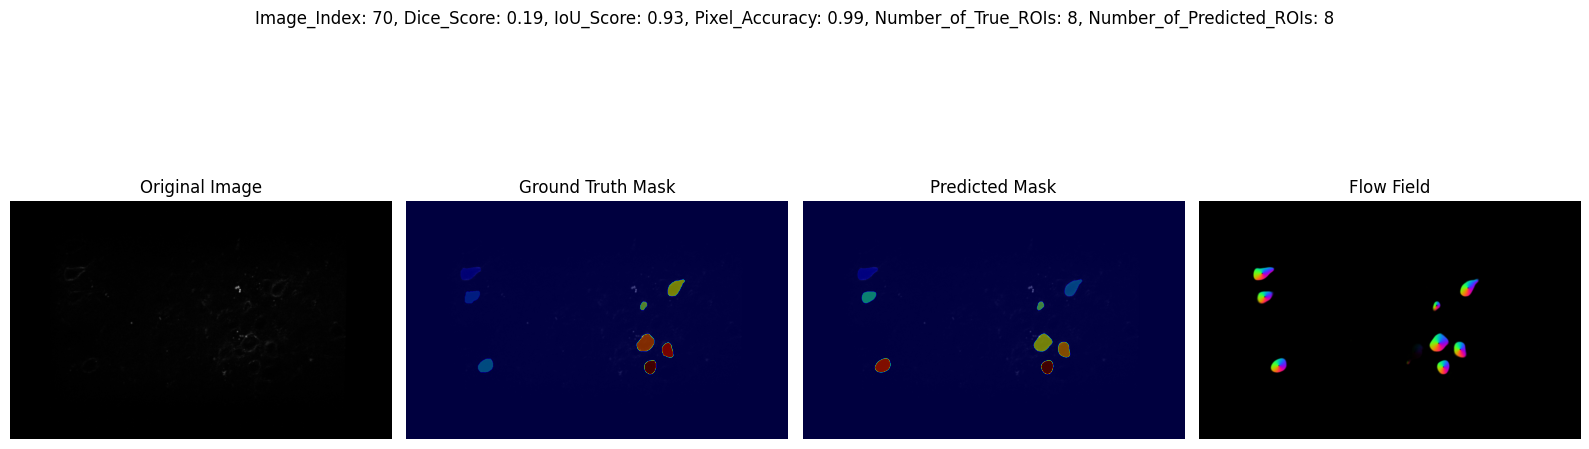

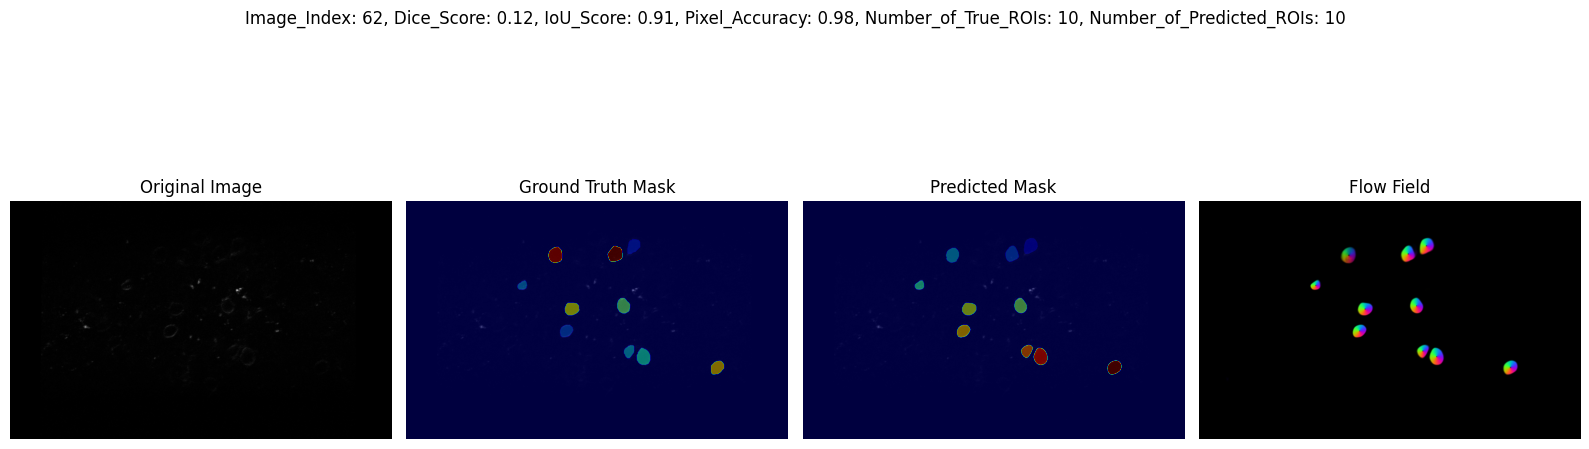

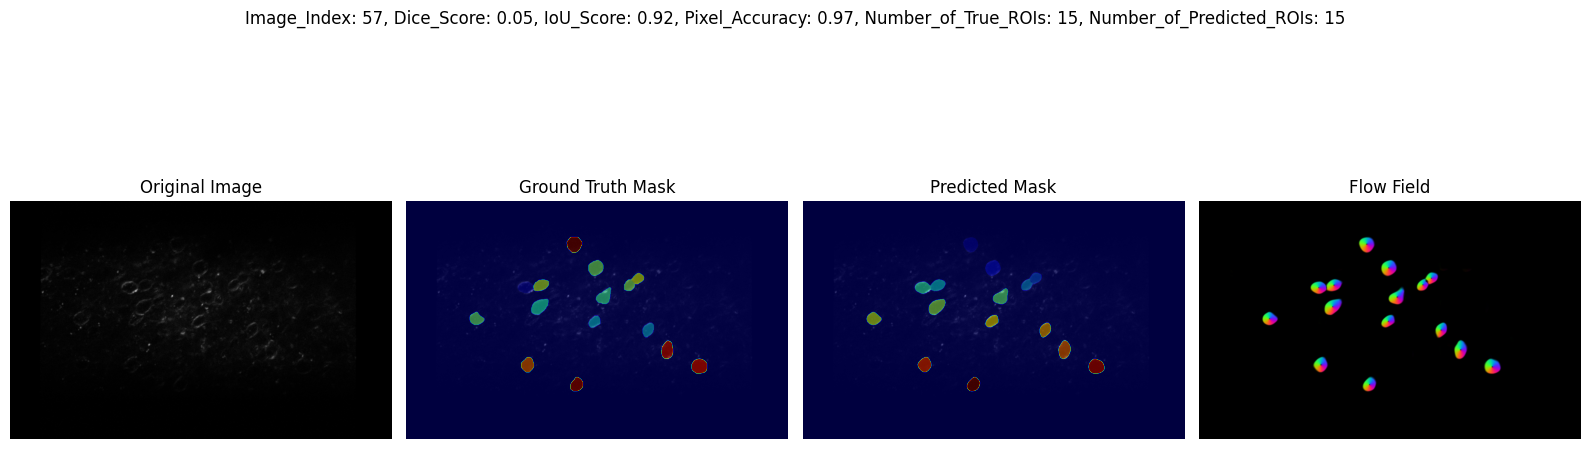

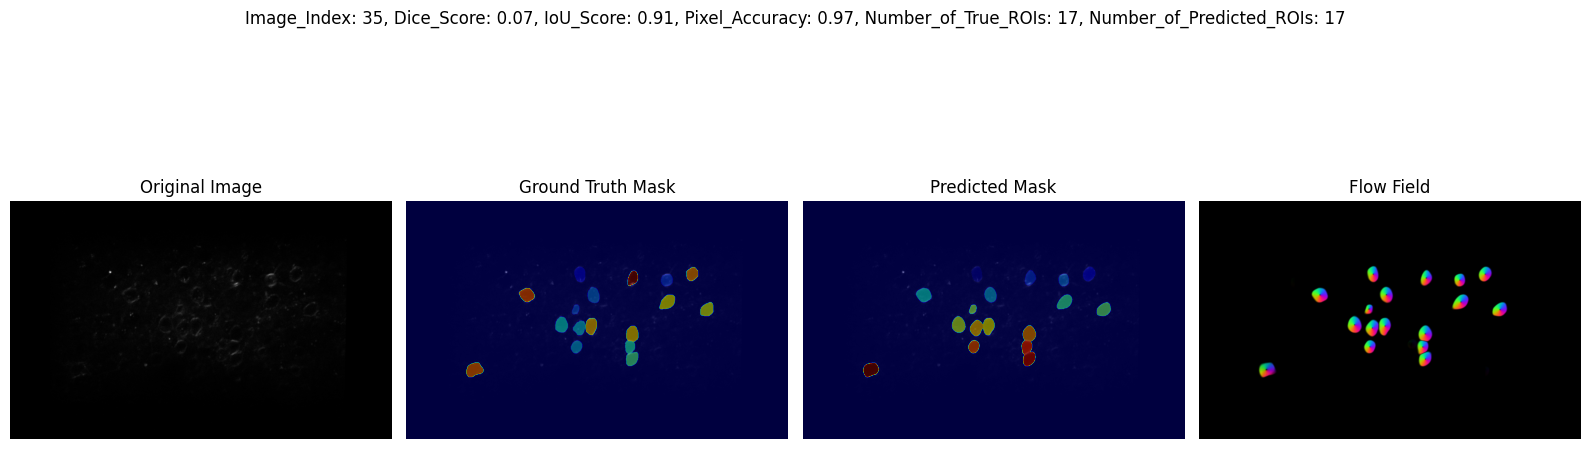

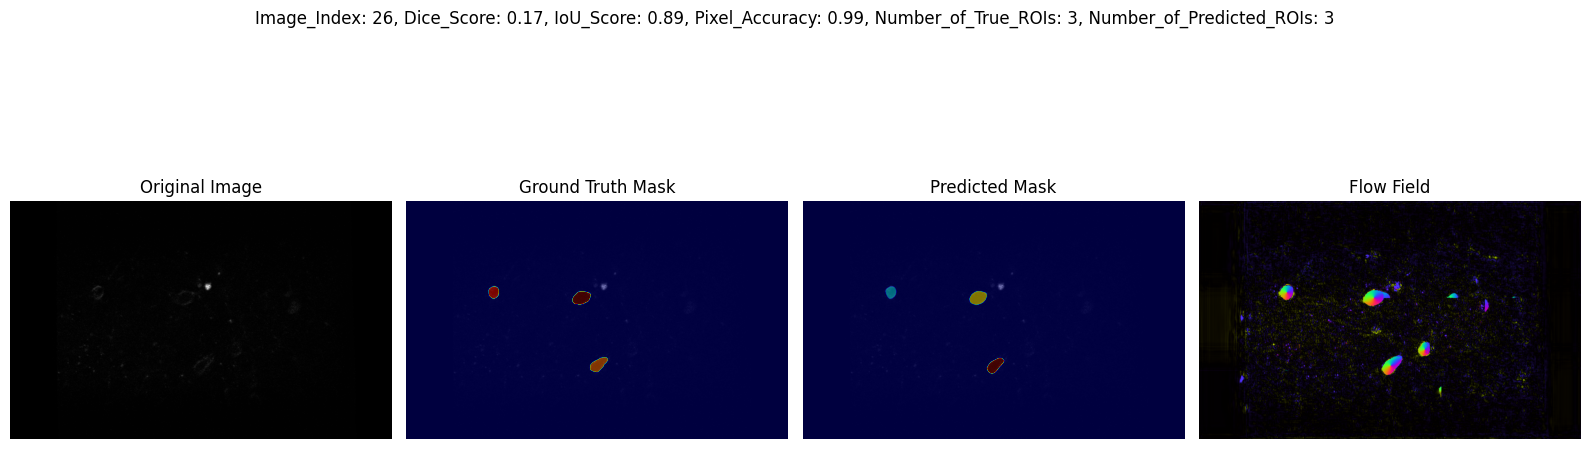

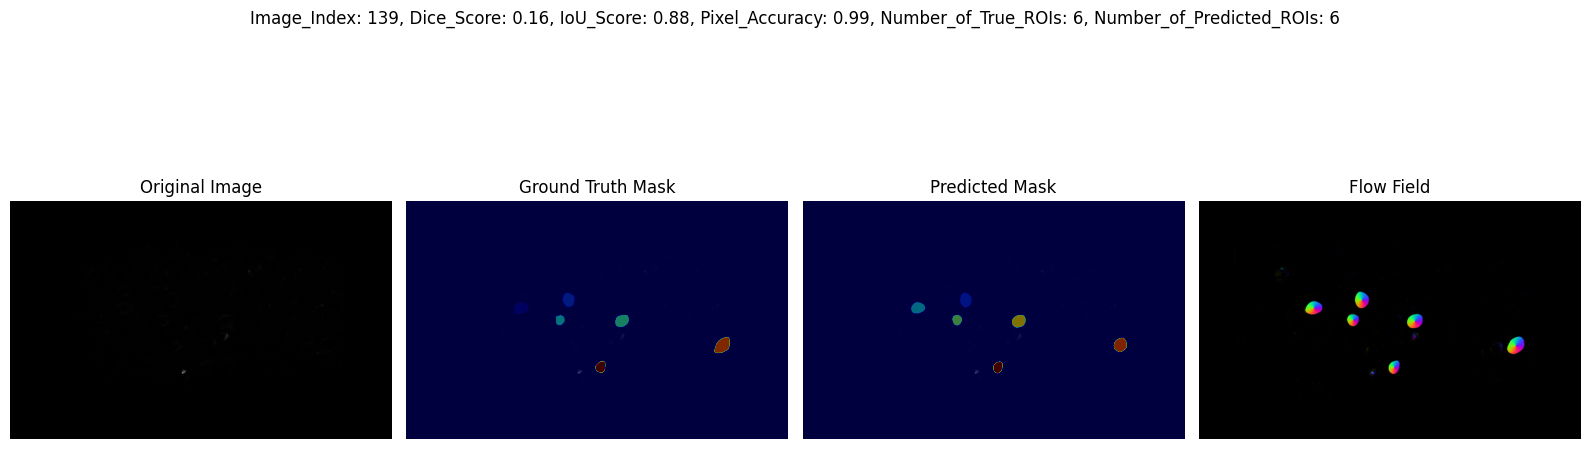

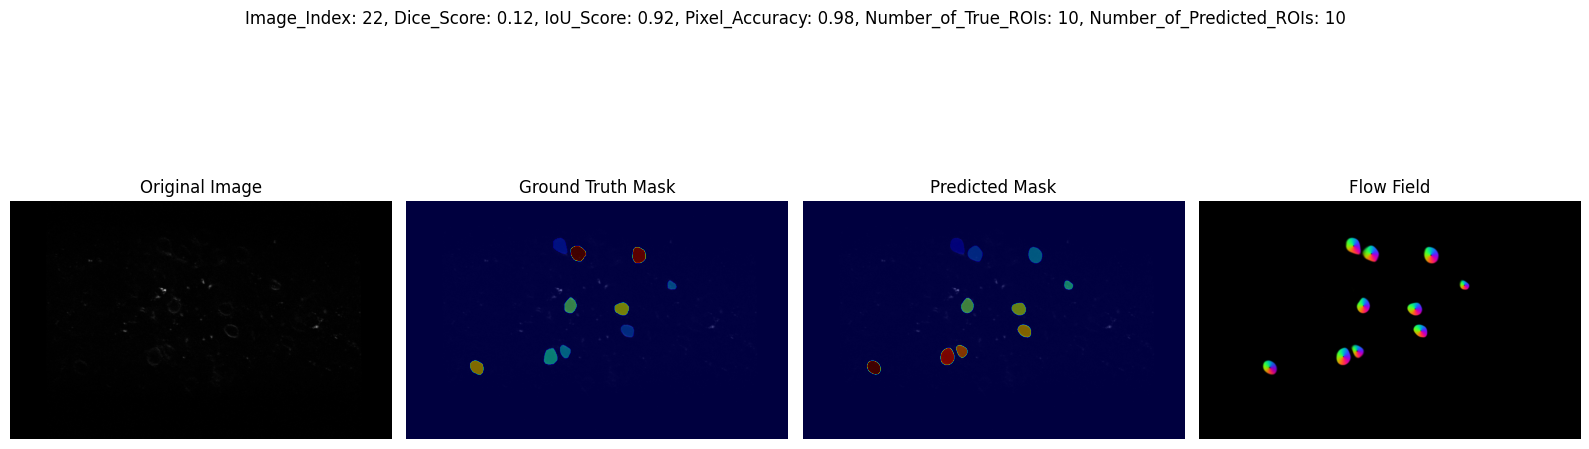

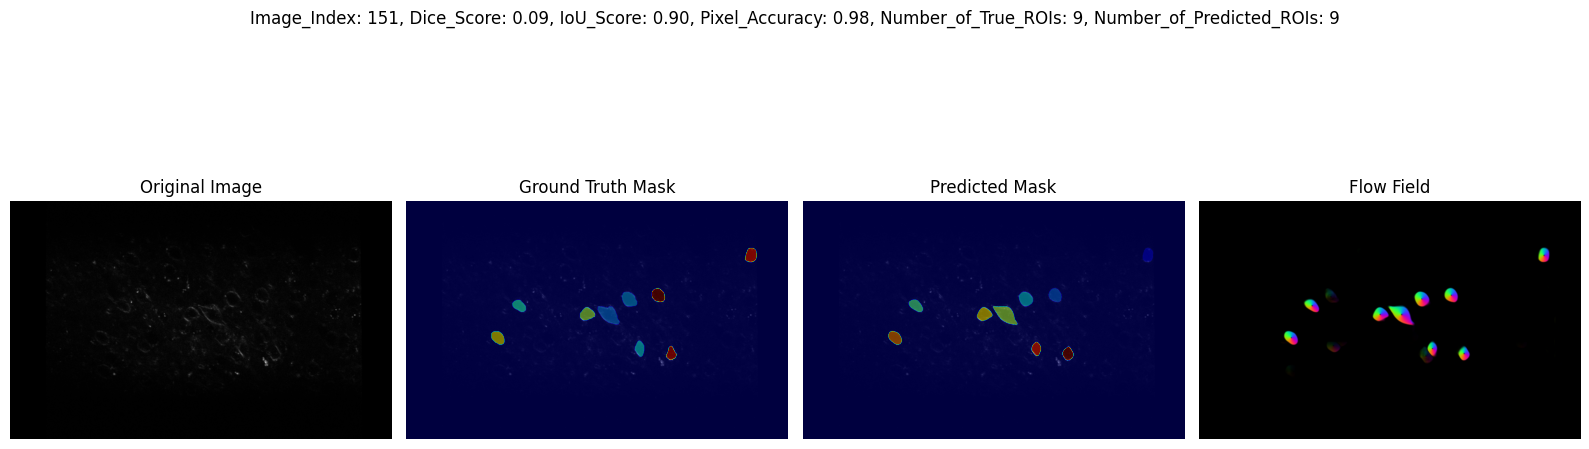

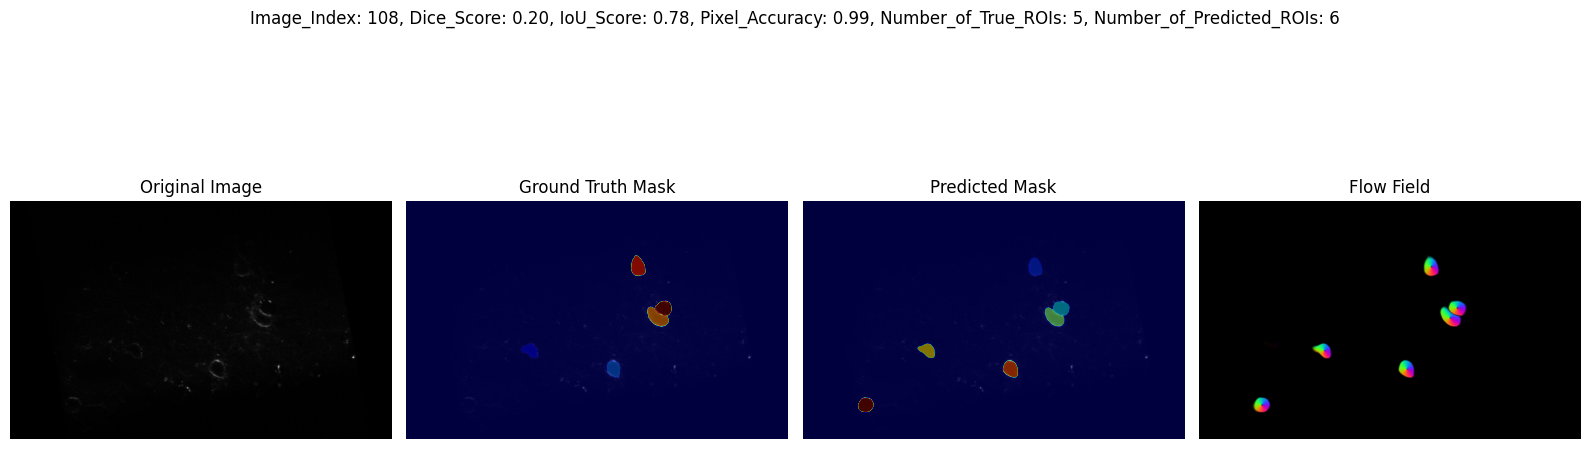

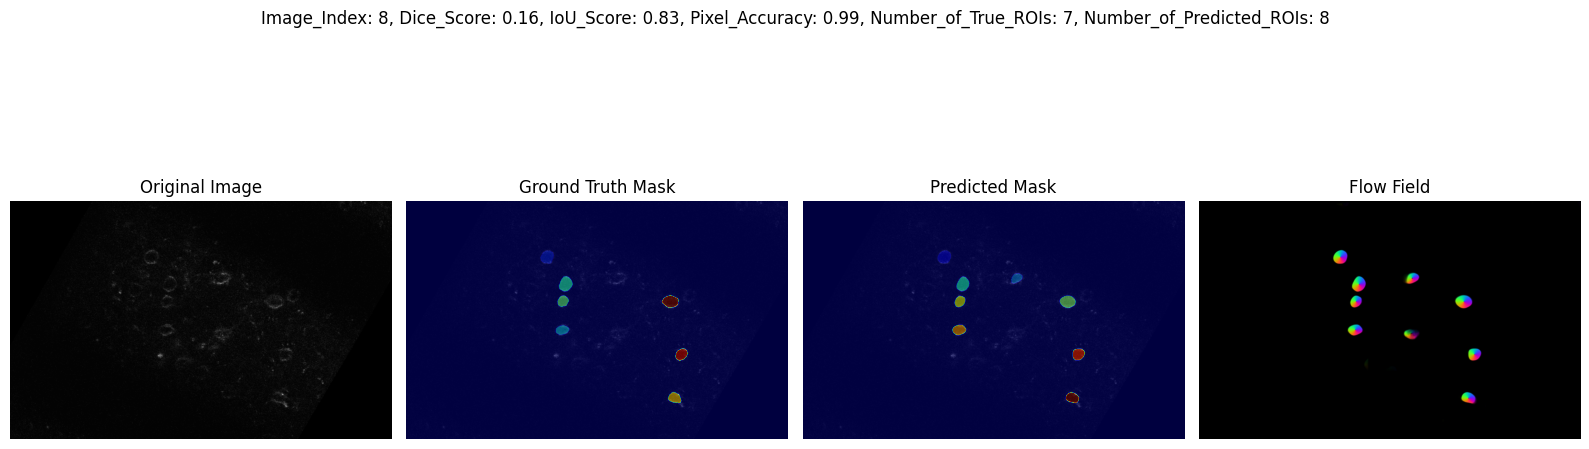

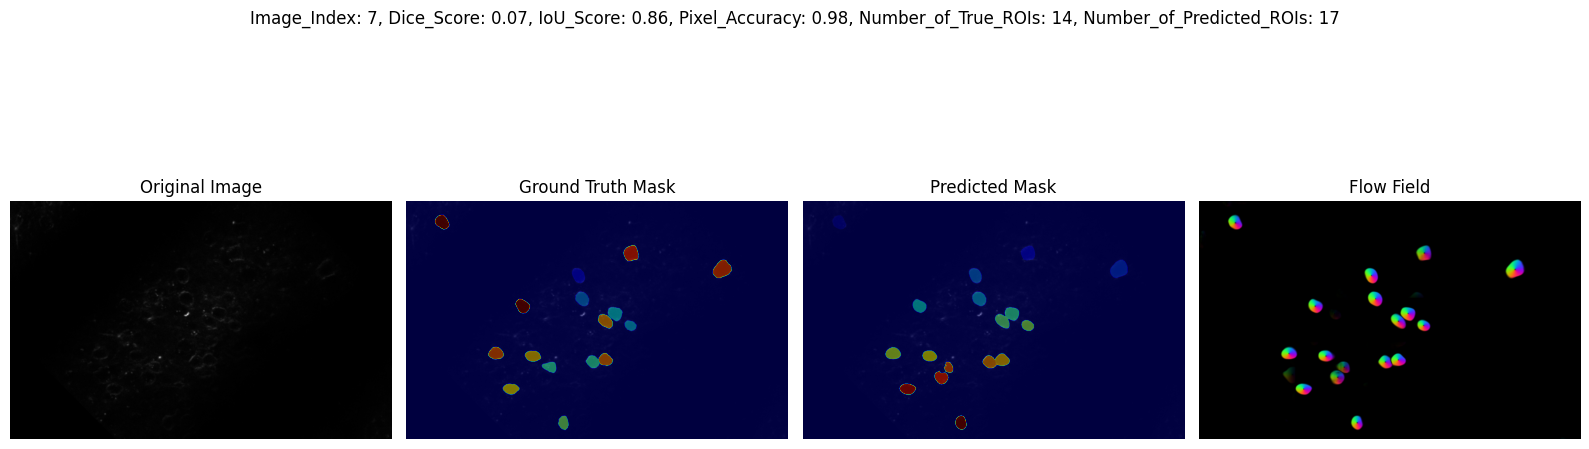

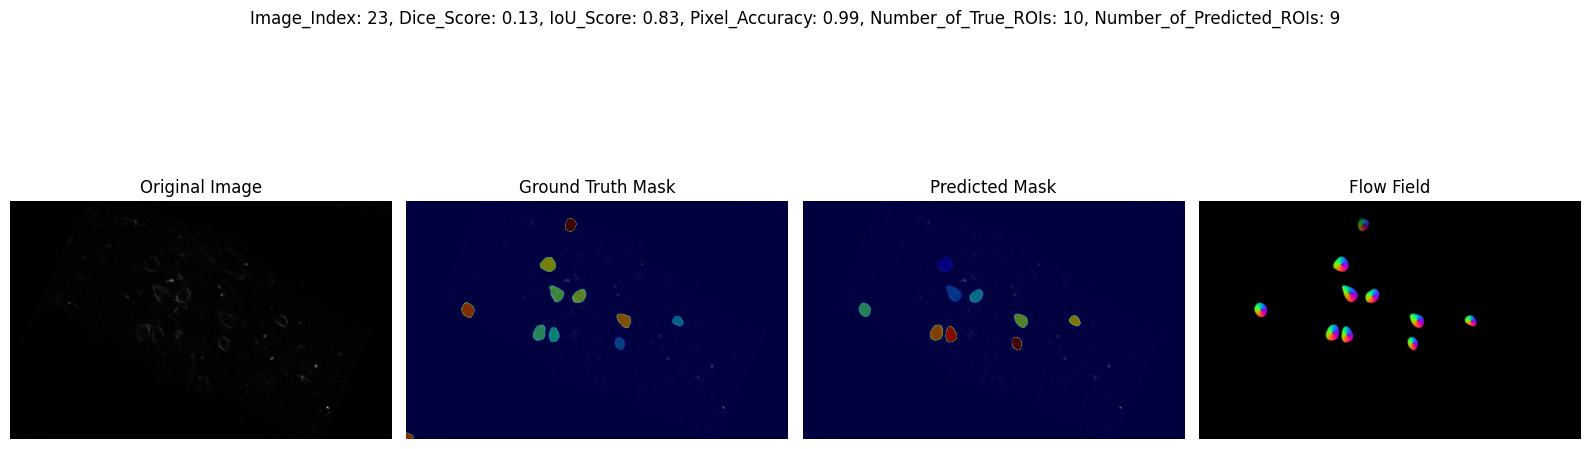

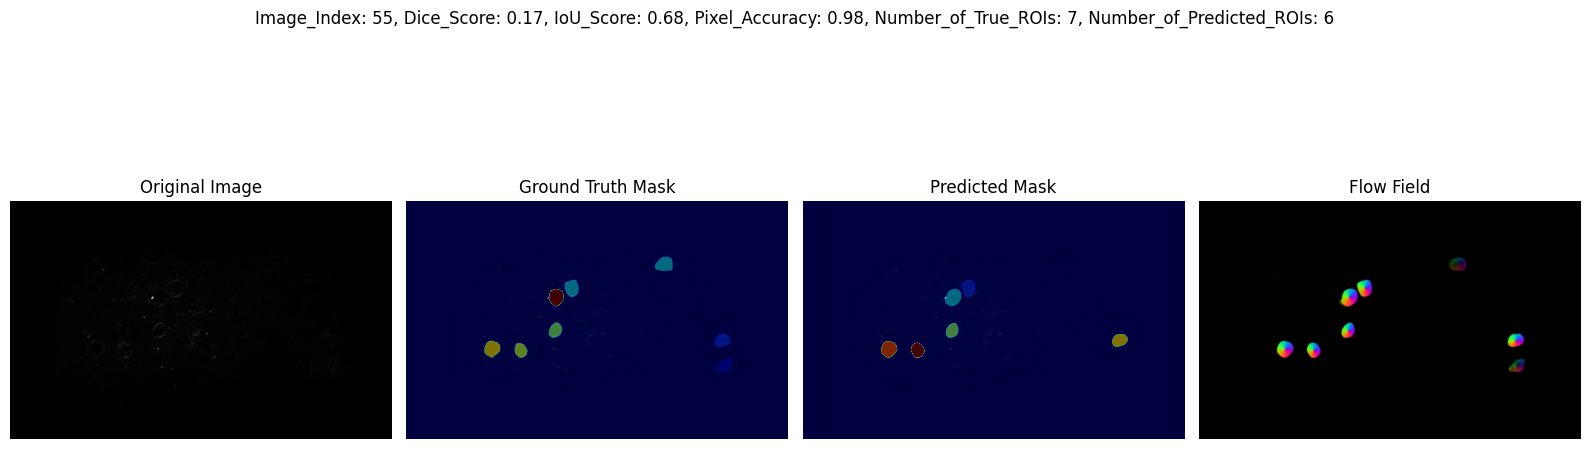

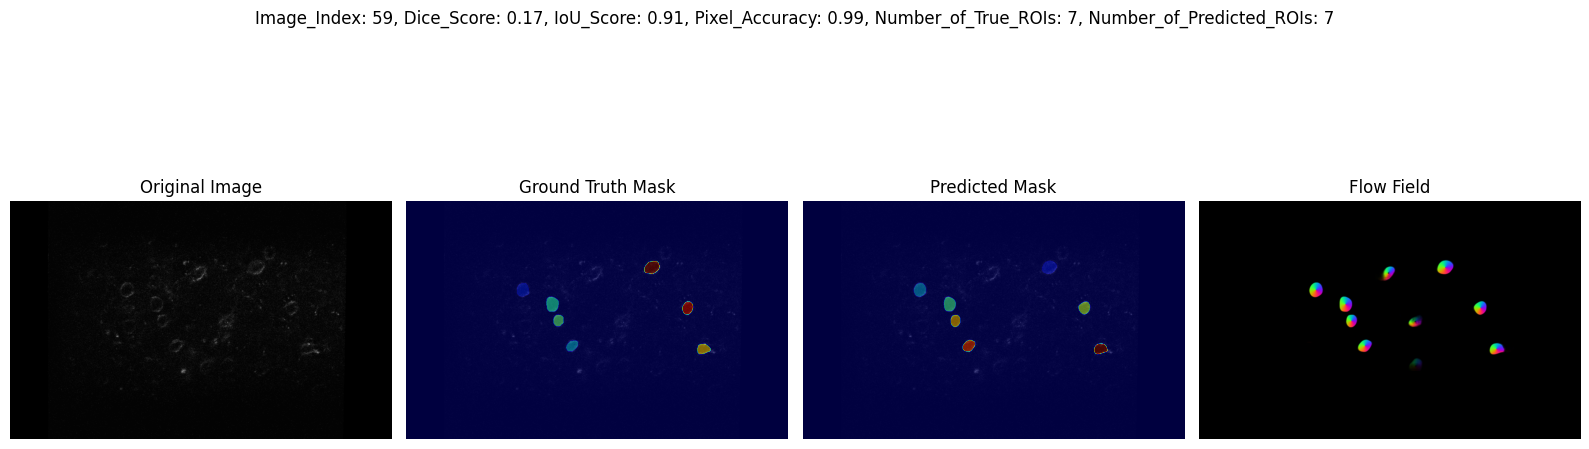

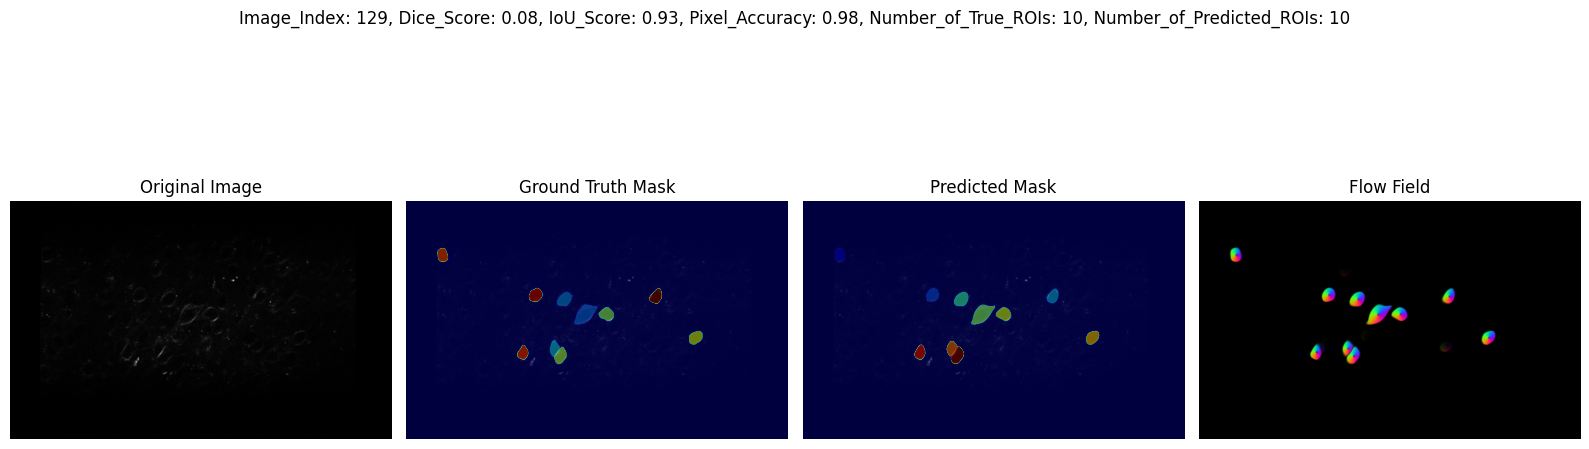

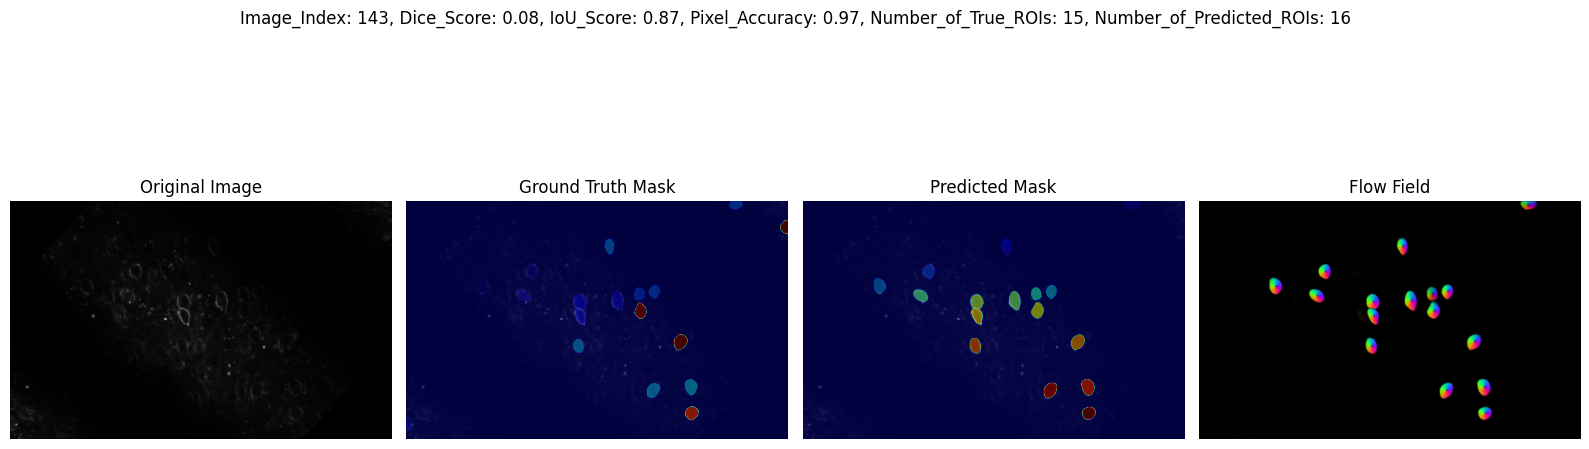

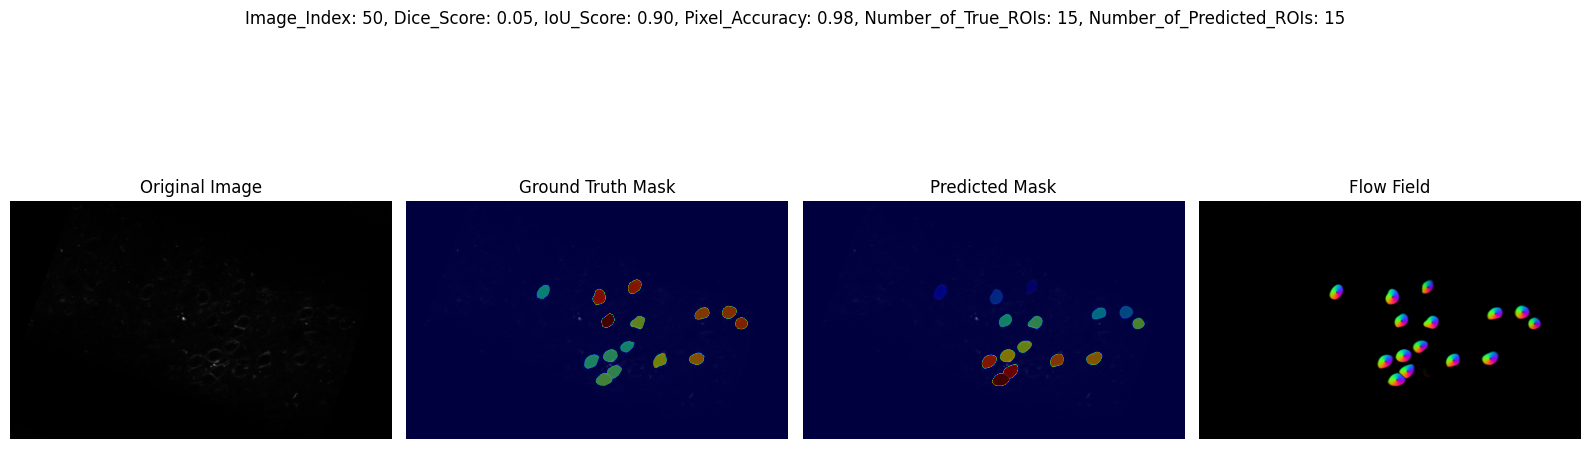

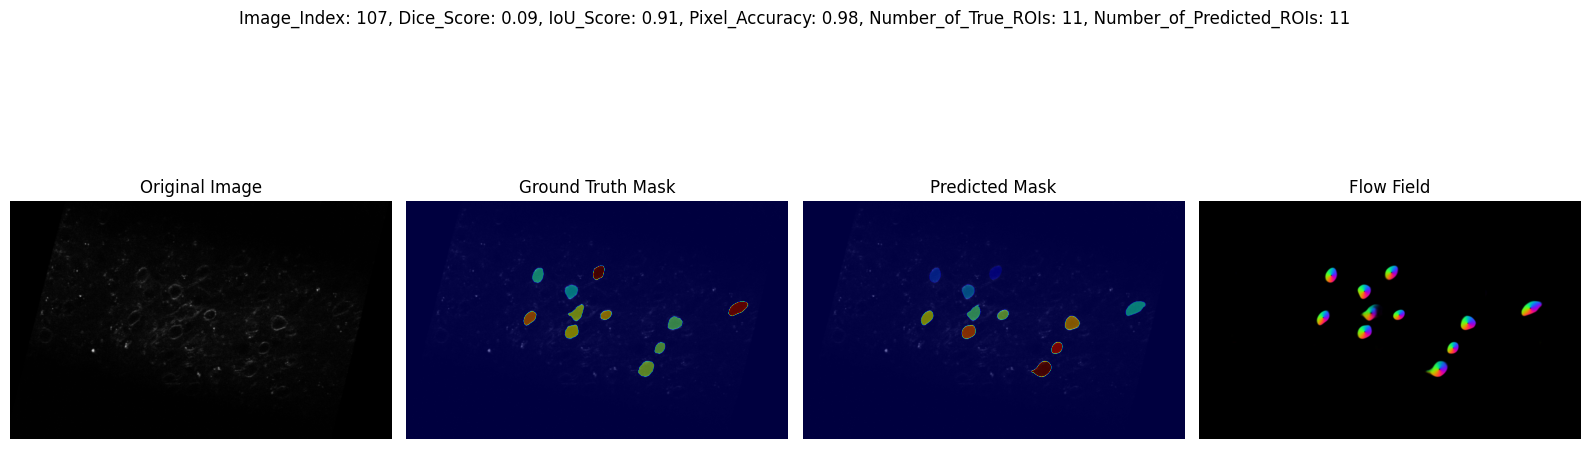

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Set a random seed for reproducibility
random.seed(42)

# Select 20 random indices from the test set
random_indices = random.sample(range(len(test_images)), 20)

# Loop through the selected random indices
for idx in random_indices:
    # Evaluate the model on the test image
    results = model.eval(test_images[idx], channels=[0, 0])
    if len(results) == 3:
        masks_pred, flows, styles = results
    else:
        masks_pred, flows, styles, diams = results

    # Calculate metrics
    metrics = calculate_metrics(test_masks[idx], masks_pred)

    # Construct the title with metrics
    title = (f"Image_Index: {idx}, "
             f"Dice_Score: {metrics['Dice Score']:.2f}, "
             f"IoU_Score: {metrics['IoU Score']:.2f}, "
             f"Pixel_Accuracy: {metrics['Pixel Accuracy']:.2f}, "
             f"Number_of_True_ROIs: {metrics['Number of True ROIs']}, "
             f"Number_of_Predicted_ROIs: {metrics['Number of Predicted ROIs']}")

    # Visualize results for the current test image
    fig, ax = plt.subplots(1, 4, figsize=(16, 6))
    fig.suptitle(title, fontsize=12)

    # Original image
    ax[0].imshow(test_images[idx], cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Ground truth mask 
    ax[1].imshow(test_images[idx], cmap='gray')
    ax[1].imshow(test_masks[idx], cmap='jet', alpha=0.5)
    ax[1].set_title('Ground Truth Mask')
    ax[1].axis('off')

    # Predicted mask
    ax[2].imshow(test_images[idx], cmap='gray')
    ax[2].imshow(masks_pred, cmap='jet', alpha=0.5)
    ax[2].set_title('Predicted Mask')
    ax[2].axis('off')

    # Flow visualization
    ax[3].imshow(flows[0], cmap='gray')
    ax[3].set_title('Flow Field')
    ax[3].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the title
    plt.show()